In [6]:
#https://learning.quantum.ibm.com/course/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFTGate
from qiskit.visualization import array_to_latex
from qiskit.quantum_info import Statevector
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator
import math
from math import pi, cos, sin
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram

theta = 0.66
m = 10  # Number of control qubits

control_register = QuantumRegister(m, name="Control")
target_register = QuantumRegister(1, name="|ψ>")
output_register = ClassicalRegister(m, name="Result")
qc = QuantumCircuit(control_register, target_register, output_register)

# Prepare the eigenvector |ψ>
qc.x(target_register)
qc.barrier()

# Perform phase estimation
for index, qubit in enumerate(control_register):
    qc.h(qubit)
    for _ in range(2**index):
        qc.cp(2 * pi * theta, qubit, target_register)
qc.barrier()

# Do inverse quantum Fourier transform
qc.compose(
    QFTGate(m).inverse(),
    inplace=True
)

# Measure everything
qc.measure(range(m), range(m))
#display(qc.draw('mpl'))

In [7]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit import transpile

backend = AerSimulator()

qc_transpiled = transpile(qc, backend)
sampler = Sampler(mode=backend)
job = sampler.run([qc_transpiled])

result = job.result()

counts = result[0].data.Result.get_counts()

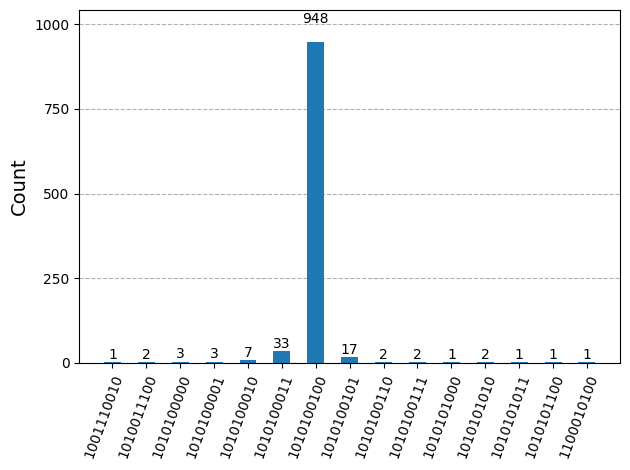

In [8]:
display(plot_histogram(counts))

In [9]:
most_probable = int(max(counts, key=counts.get), 2)

print(f"Most probable output: {most_probable}")
print(f"Estimated theta: {most_probable/2**m}")

Most probable output: 676
Estimated theta: 0.66015625


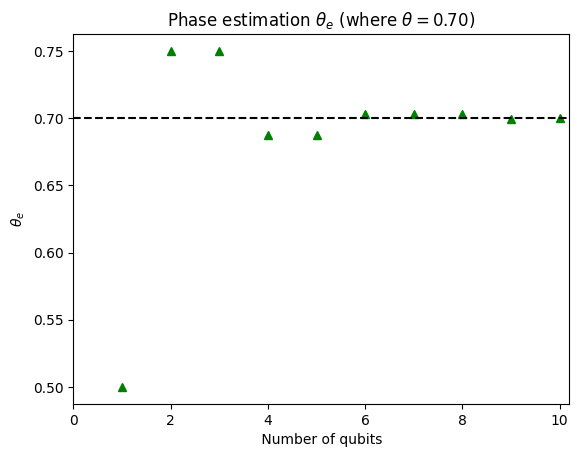

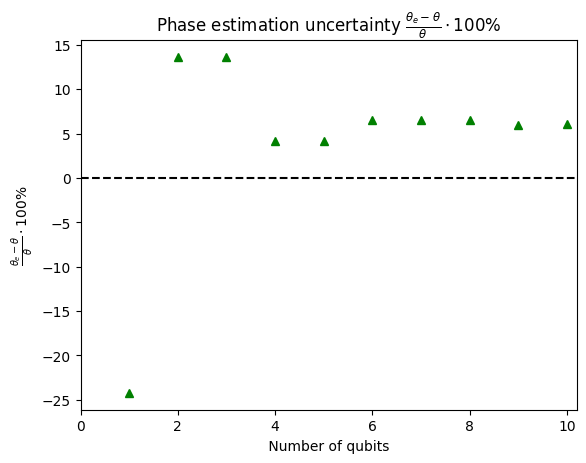

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
DaneY1=[0.5,0.75,0.75,0.6875,0.6875,0.703125,0.703125,0.703125,0.69921875,0.7001953125]
DaneX=[1,2,3,4,5,6,7,8,9,10]
DaneY2=[]
for i in range(len(DaneY1)):
    DaneYX=((DaneY1[i]-theta)/theta) *100
    DaneY2.append(DaneYX)
plt.title(u'Phase estimation $\\theta_e$ (where $\\theta=0.70$)')
plt.xlabel(r' Number of qubits ')
plt.ylabel(r'$\theta_e$')
plt.xlim([0, m+0.2])
plt.plot(DaneX,DaneY1, 'g^')
plt.hlines(y=0.70,xmin=0.0,xmax=m+0.2, colors='k', linestyles='dashed')
#path and filename of the file to plot:
outputfile = 'Phase_estimation_1_'+str(m)+'.png'
#saves the plot as pdf file in "outputfile":
plt.savefig(outputfile, dpi=300, format='png')  
plt.show()
plt.clf()


plt.title(r'Phase estimation uncertainty $\frac{\theta_e - \theta}{\theta} \cdot 100\%$')
plt.xlabel(r' Number of qubits ')
plt.ylabel(r'$\frac{\theta_e - \theta}{\theta} \cdot 100\%$')
plt.xlim([0, m+0.2])
plt.plot(DaneX,DaneY2, 'g^')
plt.hlines(y=0.0,xmin=0.0,xmax=m+0.2, colors='k', linestyles='dashed')
#path and filename of the file to plot:
outputfile = 'Phase_estimation_2_'+str(m)+'.png'
#saves the plot as pdf file in "outputfile":
plt.savefig(outputfile, dpi=300, format='png')  
plt.show()
plt.clf()


Results for theta = 0.66:
n_qubits  dh  theta_e
 1          1  0.500000
 2          3  0.750000
 3          5  0.625000
 4         11  0.687500
 5         21  0.656250
 6         42  0.656250
 7         84  0.656250
 8        169  0.660156
 9        338  0.660156
10        676  0.660156


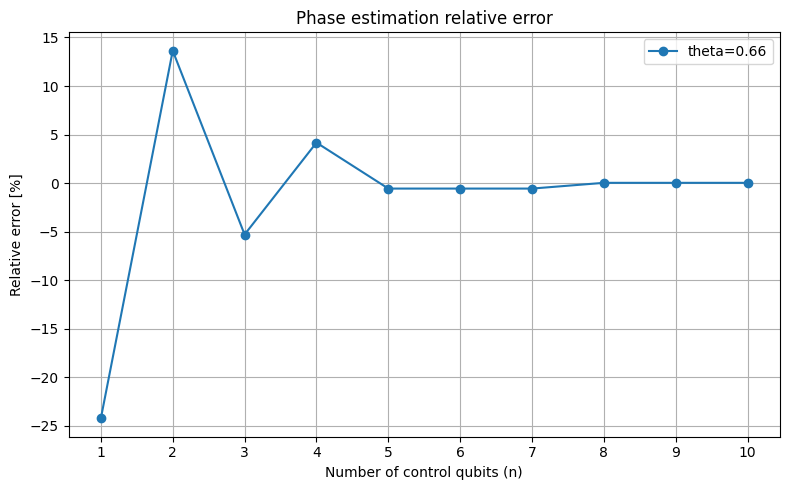

In [16]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFTGate
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
import matplotlib.pyplot as plt
import numpy as np

# ----- Function: Phase Estimation Circuit -----
def phase_estimation_circuit(n_qubits, theta):
    """
    Build a phase estimation circuit for U = Rz(2*pi*theta) with eigenstate |1>
    n_qubits: number of control qubits (top register)
    theta: phase angle (0 <= theta <= 1)
    """
    # Registers
    control = QuantumRegister(n_qubits, name="Control")
    target = QuantumRegister(1, name="|psi>")
    classical = ClassicalRegister(n_qubits, name="Result")
    qc = QuantumCircuit(control, target, classical)
    
    # Prepare eigenstate |psi> = |1>
    qc.x(target)
    qc.barrier()
    
    # Apply H gates and controlled-U^(2^k) rotations
    for k, qubit in enumerate(control):
        qc.h(qubit)
        for _ in range(2**k):
            qc.cp(2 * np.pi * theta, qubit, target)
    qc.barrier()
    
    # Apply inverse QFT on control register
    qc.append(QFTGate(n_qubits).inverse(), control)
    
    # Measure
    qc.measure(control, classical)
    
    return qc

# ----- Parameters -----
theta_list = [0.66]  
n_max = 10                   # Number of control qubits
backend = AerSimulator()
sampler = Sampler(mode=backend)

# ----- Run Phase Estimation and Collect Results -----
all_results = {}  # store results for both theta values

for theta in theta_list:
    results = []
    for n in range(1, n_max+1):
        qc = phase_estimation_circuit(n, theta)
        qc_t = transpile(qc, backend)
        job = sampler.run([qc_t])
        result = job.result()
        counts = result[0].data.Result.get_counts()
        
        # Most probable measured state
        dh = int(max(counts, key=counts.get), 2)
        theta_e = dh / 2**n
        
        results.append((n, dh, theta_e))
    all_results[theta] = results

# ----- Print Tables -----
for theta in theta_list:
    print(f"\nResults for theta = {theta}:")
    print("n_qubits  dh  theta_e")
    for row in all_results[theta]:
        print(f"{row[0]:>2}        {row[1]:>3}  {row[2]:.6f}")

# ----- Plot Percentage Error -----
plt.figure(figsize=(8,5))
for theta in theta_list:
    theta_e_list = [row[2] for row in all_results[theta]]
    perc_error = [100*(te - theta)/theta for te in theta_e_list]
    plt.plot(range(1, n_max+1), perc_error, marker='o', label=f"theta={theta}")
plt.xlabel("Number of control qubits (n)")
plt.ylabel("Relative error [%]")
plt.title("Phase estimation relative error")
plt.xticks(range(1, n_max+1))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("PhaseEstimation_Error.png", dpi=300)
plt.show()
